In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import math
from scipy import stats
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import brentq

# Case 7: Option Pricing with the Heston Model

## Monte-Carlo

In [ ]:
V0 = 0.1**2
S0 = np.log(100)
lambda_ = 2
theta = 0.1**2
T = 10
sigma_v = 0.1
n_steps = 100
n_simulations = 100000
rho = -0.5
r = 0.02

In [ ]:
# Parameters
S0 = 100        # Initial stock price
r = 0.02        # Risk-free rate
T = 10          # Maturity time (in years)
strikes = np.arange(50, 201, 10)  # Strike prices
numSim = 1000000  # Reduced number of Monte Carlo simulations
time_steps = 100  # Reduced number of time steps

# Heston Model Parameters
theta = 0.1**2  # Long-term variance
kappa = 2       # Mean-reversion rate
sigma_v = 0.1   # Volatility of volatility
rho = -0.5      # Correlation between W_S and W_V
V0 = 0.1**2     # Initial variance

In [64]:
# Exercise 1
def monte_carlo_simulation_heston(V0, S0, kappa, theta, T, sigma_v, N, M, rho, r):

    dt = T / N  

    Z_S = np.random.normal(size=(N, M)) 
    Z_V = np.random.normal(size=(N, M)) 

    W_S = Z_S
    W_V = rho * Z_S + np.sqrt(1 - rho**2) * Z_V

    S = np.full(M, np.log(S0))
    V = np.full(M, V0)

    #np.random.seed(0)  # For reproducibility

    for t in range(N):
        sqrt_v = np.sqrt(np.maximum(V, 0))
        S += (r - 0.5 * V) * dt + sqrt_v * np.sqrt(dt) * W_S[t]
        V += kappa * (theta - V) * dt + sigma_v * sqrt_v * np.sqrt(dt) * W_V[t]
        V = np.maximum(V, 0)  

    S_T_heston = np.exp(S)
    return S_T_heston

V0 = 0.1**2
S0 = 100
lambda_ = 2
theta = 0.1**2
T = 10
sigma_v = 0.1
time_steps = 100
numSim = 1000000
rho = -0.5
r = 0.02

S_T_heston = monte_carlo_simulation_heston(V0, S0, kappa, theta, T, sigma_v, time_steps, numSim, rho, r)
S_T_heston


array([ 94.40789097, 150.50358362, 124.07522973, ..., 100.26134171,
        75.17210917,  76.36933303])

In [ ]:
# Calculate call option prices for each strike
call_prices_heston = []
SE = []
discount_factor = np.exp(-r*T)

for K in strikes:
    # Heston model prices
    payoffs_heston = np.maximum(S_T_heston - K, 0)
    price_heston = np.exp(-r * T) * np.mean(payoffs_heston)
    payoff_std = np.std(payoffs_heston)
    se = discount_factor * payoff_std / np.sqrt(numSim)

    call_prices_heston.append(price_heston)
    SE.append(se)


# Display results
print("Strike\tHeston Call Price")
for K, price_heston, se in zip(strikes, call_prices_heston, SE):
    print(f"{K}\t{price_heston:} ± {se:}")


Strike	Heston Call Price
50	59.058624034014656 ± 0.03160239767820745
60	50.99648375645509 ± 0.0313868696852583
70	43.15487232945375 ± 0.03087075870482115
80	35.71388657104994 ± 0.02991358446511778
90	28.86653447971453 ± 0.028446832472632924
100	22.779734998253307 ± 0.02649273349934063
110	17.5596331599988 ± 0.02415355353201692
120	13.2371750235883 ± 0.02157734406033555
130	9.770686600088235 ± 0.01892317290180875
140	7.076595142500846 ± 0.016325354247522253
150	5.036555853408148 ± 0.013887563498385457
160	3.5287091995157565 ± 0.011674782939316366
170	2.438862083829533 ± 0.009718252955977143
180	1.6658794001833364 ± 0.008023828581459188
190	1.1252150939437102 ± 0.006581047793712232
200	0.7532277287787588 ± 0.005368603346793097


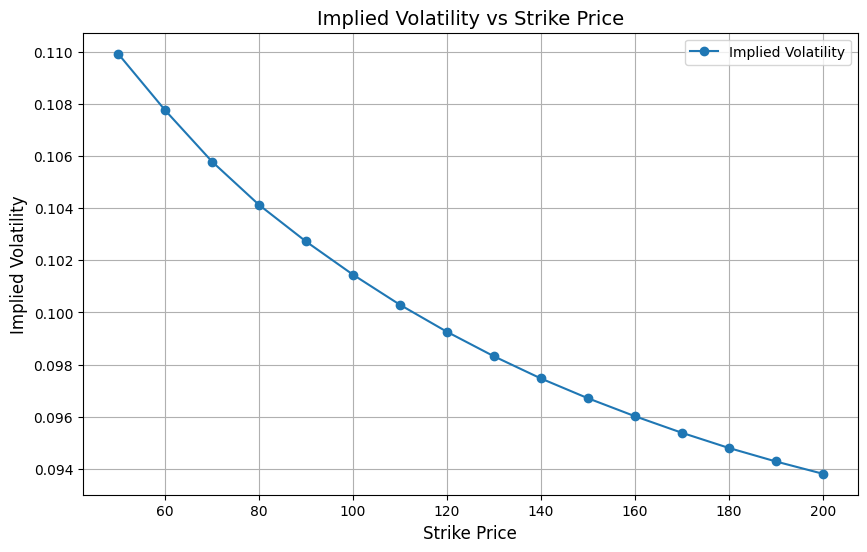

In [41]:
heston_prices = [59.0989, 51.0349, 43.1889, 35.7423, 28.8939, 
                 22.8067, 17.5841, 13.2574, 9.7874, 7.0874, 
                 5.0446, 3.5350, 2.4425, 1.6670, 1.1264, 0.7544, 0.5003,
0.3304,0.2168,0.1419,0.0924,0.0599,0.0388,0.0254,0.0168,0.0110,               
0.0071,0.0046,0.0029,0.0018,0.0012]

def BlackScholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def impliedVolatility(price, S, K, T, r):
    def objFunc(sigma):
        return BlackScholes_call(S, K, T, r, sigma) - price
    try:
        # brentq root-finding (numerical method) used to solve for sigma 
        return brentq(objFunc, 1e-6, 5)
    except ValueError:
        return np.nan

impliedVolatilities = []
for K, price in zip(strikes, heston_prices):
    impVol = impliedVolatility(price, S0, K, T, r)
    impliedVolatilities.append(impVol)

plt.figure(figsize=(10, 6))
plt.plot(strikes, impliedVolatilities, marker='o', label='Implied Volatility')
plt.title("Implied Volatility vs Strike Price", fontsize=14)
plt.xlabel("Strike Price", fontsize=12)
plt.ylabel("Implied Volatility", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


## Fourier Transform

K=50, Optimal Alpha=2.48042
K=60, Optimal Alpha=2.78851
K=70, Optimal Alpha=3.11060
K=80, Optimal Alpha=3.47470
K=90, Optimal Alpha=3.86682
K=100, Optimal Alpha=4.30094
K=110, Optimal Alpha=4.76307
K=120, Optimal Alpha=5.23921
K=130, Optimal Alpha=5.74335
K=140, Optimal Alpha=6.26150
K=150, Optimal Alpha=6.79365
K=160, Optimal Alpha=7.33981
K=170, Optimal Alpha=7.88597
K=180, Optimal Alpha=8.43212
K=190, Optimal Alpha=8.97828
K=200, Optimal Alpha=9.52443


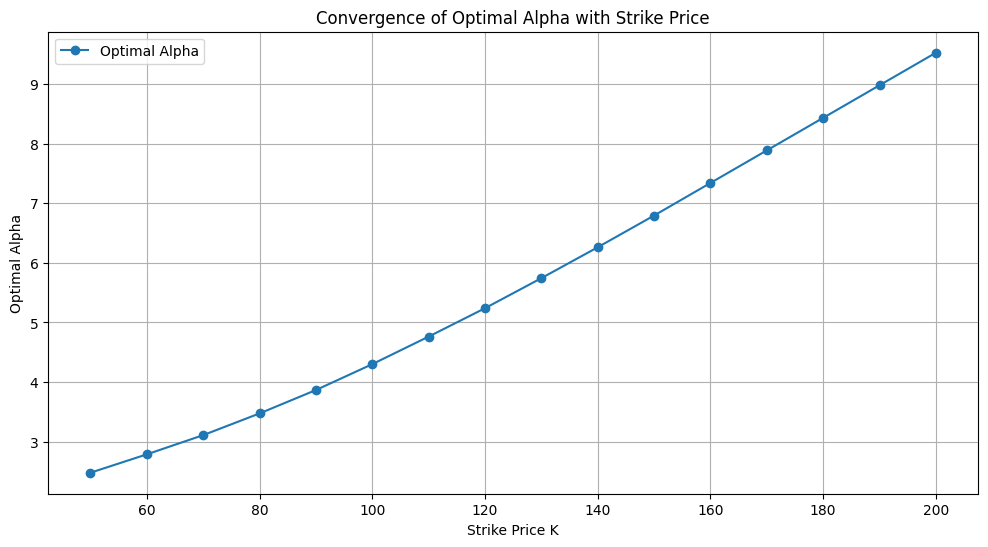

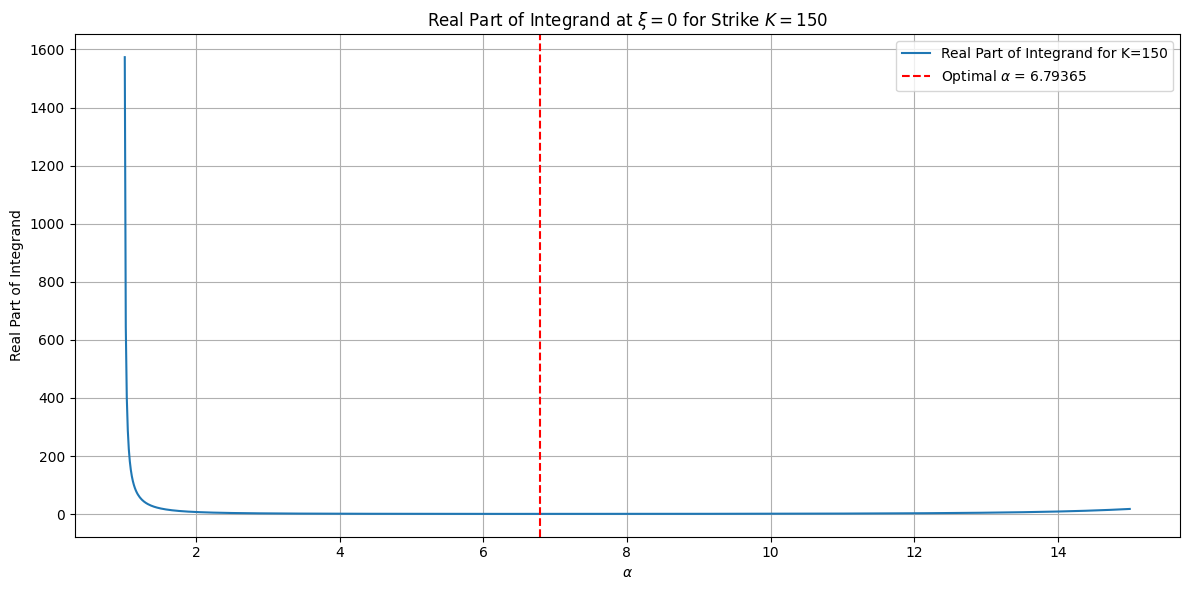

In [74]:
# Exercise 2: Find Alphas
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Heston Characteristic Function
def heston_charfct(xi, V_t, x_t, T, t, r, kappa, theta, sigma_v, rho):
    d = np.sqrt((rho * sigma_v * 1j * xi - kappa)**2 + sigma_v**2 * (1j * xi + xi**2))
    C = (
        ((1j * xi + xi**2) * (1 - np.exp(d * (T - t)))) /
        ((rho * sigma_v * 1j * xi - kappa) * (1 - np.exp(d * (T - t))) + d * (1 + np.exp(d * (T - t))))
    )
    A = (
        1j * xi * r * (T - t)
        + ((kappa * theta) / (sigma_v**2)) * (
            (d - (1j * rho * sigma_v * xi - kappa)) * (T - t)
            - 2 * np.log(
                ((1 - np.exp(d * (T - t))) * (1j * rho * xi * sigma_v - kappa) + d * (1 + np.exp(d * (T - t)))) / (2 * d)
            )
        )
    )
    return np.exp(A + C * V_t + 1j * xi * x_t)

# Fourier Transform of Tilted Call Payoff
def FT_tilted_payoff(alpha, xi, K, T, r):
    term1 = -np.exp((1 - alpha + 1j * xi) * np.log(K)) / (1 - alpha + 1j * xi)
    term2 = K * np.exp((-alpha + 1j * xi) * np.log(K)) / (-alpha + 1j * xi)
    return np.exp(-r * T) * (term1 + term2)

# Auxiliary Integration Function
def integrand_FT(xi, alpha, V_t, x_t, T, t, K, r, kappa, theta, sigma_v, rho):
    char_func = heston_charfct(-xi - 1j * alpha, V_t, x_t, T, t, r, kappa, theta, sigma_v, rho)
    payoff_ft = FT_tilted_payoff(alpha, xi, K, T, r)
    return np.real(char_func * payoff_ft / (2 * np.pi))

# Parameters
S0 = 100       # Initial stock price
T = 10         # Time to maturity
r = 0.02       # Risk-free rate
kappa = 2.0    # Mean reversion speed
theta = 0.01   # Long-term variance
sigma_v = 0.1  # Volatility of variance
rho = -0.5     # Correlation between Brownian motions
V_t = 0.01     # Current variance
x_t = np.log(S0)  # Logarithm of stock price
t = 0          # Current time

# Range of strike prices
strike_prices = np.arange(50, 201, 10)

# Store optimal alphas for each strike price
optimal_alphas = []

for K in strike_prices:
    # Range of alpha values
    alpha_values = np.linspace(1.01, 15.0, 1000)
    xi = 0  # Fix xi = 0

    # Compute real part of the integrand for different alpha values
    real_parts = [integrand_FT(xi, a, V_t, x_t, T, t, K, r, kappa, theta, sigma_v, rho) for a in alpha_values]

    # Find the optimal alpha
    optimal_alpha = alpha_values[np.argmin(real_parts)]
    optimal_alphas.append(optimal_alpha)
    print(f"K={K}, Optimal Alpha={optimal_alpha:.5f}")

# Plot the convergence of optimal alpha with strike price
plt.figure(figsize=(12, 6))
plt.plot(strike_prices, optimal_alphas, marker='o', label="Optimal Alpha")
plt.xlabel("Strike Price K")
plt.ylabel("Optimal Alpha")
plt.title("Convergence of Optimal Alpha with Strike Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot Real Part of Integrand for a Specific Strike Price
def plot_real_part_integrand(K):
    alpha_values = np.linspace(1.01, 15.0, 1000)
    xi = 0  # Fix xi = 0

    # Compute real parts of the integrand
    real_parts = [integrand_FT(xi, a, V_t, x_t, T, t, K, r, kappa, theta, sigma_v, rho) for a in alpha_values]

    # Find the optimal alpha
    optimal_alpha = alpha_values[np.argmin(real_parts)]

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(alpha_values, real_parts, label=f"Real Part of Integrand for K={K}")
    plt.axvline(optimal_alpha, color='r', linestyle='--', label=rf"Optimal $α$ = {optimal_alpha:.5f}")
    plt.xlabel(r"$α$")
    plt.ylabel(r"Real Part of Integrand")
    plt.title(rf"Real Part of Integrand at $ξ=0$ for Strike $K={K}$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Test the plot for a specific strike price
plot_real_part_integrand(150)



Call Option Price for K=50: 59.09994
Call Option Price for K=60: 51.03639
Call Option Price for K=70: 43.19218
Call Option Price for K=80: 35.74675
Call Option Price for K=90: 28.89594
Call Option Price for K=100: 22.80699
Call Option Price for K=110: 17.58460
Call Option Price for K=120: 13.25824
Call Option Price for K=130: 9.78928
Call Option Price for K=140: 7.08995
Call Option Price for K=150: 5.04568
Call Option Price for K=160: 3.53459
Call Option Price for K=170: 2.44138
Call Option Price for K=180: 1.66535
Call Option Price for K=190: 1.12358
Call Option Price for K=200: 0.75082


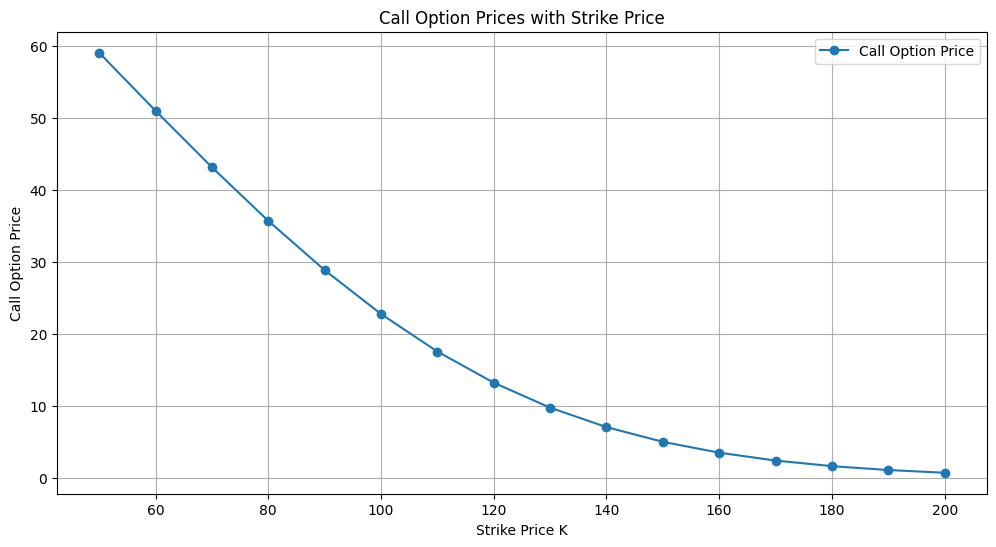

In [78]:
# ex 3


# Integration over xi for call option price
def call_price_heston(alpha, V_t, x_t, T, t, K, r, kappa, theta, sigma_v, rho):

    def integrand(xi):
        return integrand_FT(xi, alpha, V_t, x_t, T, t, K, r, kappa, theta, sigma_v, rho)
    
    # Perform numerical integration over xi
    integral_result, _ = quad(integrand, -100, 100)  # Adjust integration limits as needed
    return integral_result

# Compute and print call option prices
call_option_prices = []

for K in strike_prices:
    # Use the corresponding optimal alpha for the strike price
    optimal_alpha = optimal_alphas[strike_prices.tolist().index(K)]
    
    # Compute the call option price
    price = call_price_heston(optimal_alpha, V_t, x_t, T, t, K, r, kappa, theta, sigma_v, rho)
    call_option_prices.append(price)
    print(f"Call Option Price for K={K}: {price:.5f}")

# Plot the call option prices against strike prices
plt.figure(figsize=(12, 6))
plt.plot(strike_prices, call_option_prices, marker='o', label="Call Option Price")
plt.xlabel("Strike Price K")
plt.ylabel("Call Option Price")
plt.title("Call Option Prices with Strike Price")
plt.legend()
plt.grid(True)
plt.show()


# Strike	Heston Call Price
# 50	59.058624034014656 ± 0.03160239767820745
# 60	50.99648375645509 ± 0.0313868696852583
# 70	43.15487232945375 ± 0.03087075870482115
# 80	35.71388657104994 ± 0.02991358446511778
# 90	28.86653447971453 ± 0.028446832472632924
# 100	22.779734998253307 ± 0.02649273349934063
# 110	17.5596331599988 ± 0.02415355353201692
# 120	13.2371750235883 ± 0.02157734406033555
# 130	9.770686600088235 ± 0.01892317290180875
# 140	7.076595142500846 ± 0.016325354247522253
# 150	5.036555853408148 ± 0.013887563498385457
# 160	3.5287091995157565 ± 0.011674782939316366
# 170	2.438862083829533 ± 0.009718252955977143
# 180	1.6658794001833364 ± 0.008023828581459188
# 190	1.1252150939437102 ± 0.006581047793712232
# 200	0.7532277287787588 ± 0.005368603346793097

